<a href="https://colab.research.google.com/github/pe44enka/HousePriceChallendge/blob/master/Copy_of_HousePriceChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **House Price Prediction**

![](https://storage.googleapis.com/kaggle-datasets-images/128/270/d149695d1f9a97ec54cf673be6430ad7/dataset-original.jpg)


### Objectives

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. If we look closer at the dataset describing (almost) every aspect of houses we can see there are much more influences price negotiations than the number of bedrooms or a white-picket fence.

---

### Goal of the project
To built ML model to predict the final price of each House.

### Data
[Price of Residential Houses in Ames, Iowa](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview) dataset available at Kaggle as part of competition.

### Techniques
In this projects we will use:
* **Data preprocessing:** SelectFromModel, SimpleImputer, OneHotEncoder, StandardScaler, ColumnTransformer, pandas.get_dummies
* **ML algorihms**: LinearRegression, DecisionTreeRegressor RandomForestRegressor, GradientBoostingRegressor, XGBRegressor 
* **Hyperparameter turning:** GridSearchCV
* **Model traing/applying:** Pipeline, tran_test_split


---

# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

# Load Data

In [2]:
df =  pd.read_csv('https://raw.githubusercontent.com/pe44enka/HousePriceChallendge/master/data/Housing.csv')
print("df.shape: ", df.shape)
df.head()

df.shape:  (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Data Analysis and Feature Selection


Before playing with ML models and trying to predict anything let's get ourselves familiar with data we have.

---



In [3]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC


As we can see we have plenty of mixed categorical and numerical features as well as missing values in our data. For further analysis and feature selection we need to get rid of these 2 Achilles heels of ML.

---



### Missing Data

Let's have a look on features with missing values.

---

In [3]:
df[df.columns[df.isna().sum().values > 0]].isna().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64



---

After short analysis of features with missing values that is how we will deal with them:
* drop all categorical features with more than 50% of missing values:
  * `Alley`
  * `FireplaceQu`
  * `PoolQC`
  * `Fence`
  * `MiscFeature`
* drop features with unique values in each row (like id) as far as they bring no useful info for the future model:
  * `id`
* fill missing values of numerical features with mean of the  particular column:
  * `LotFrontage`
  * `MasVnrArea`
  * `GarageYrBlt`
* drop rows with all remaining missing values as far as these values are categorical and it's pretty hard to predict with what value to fill them with. 

**Notes:** 
1. with last action we loose about 8% of our data. It's acceptable for this project, but may be critical for other one
2. droping rows cause gaps in indices of DataFrame so we need to reset them

---



In [4]:
#drop categorical columns with more than 50% of missing values & features with unique values
df.drop(columns=['Id', 'Alley', 'FireplaceQu','PoolQC', 'Fence', 'MiscFeature'], inplace=True)

#fill NaN of numerical columns with mean of the  particular column
df['LotFrontage'] = df.LotFrontage.fillna(df.LotFrontage.mean())
df['MasVnrArea'] = df.MasVnrArea.fillna(int(df.MasVnrArea.mean())).astype(int)
df['GarageYrBlt'] = df.GarageYrBlt.fillna(int(df.GarageYrBlt.mean())).astype(int)

#drop others missing values in categorical columns
df.dropna(inplace=True)

#reset indices
df = df.reset_index().drop(columns=['index'])

print('df.shape: ', df.shape)

df.shape:  (1338, 75)


In [5]:
#final check for NaN
df.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

### Categorical Data


Next step is dealing with categorical values. For purpose of analysis we will use `pd.get_dummies` algorithm because it's convinient.

**Note:** in further ML model for prediction of price OneHotEncoder will be used because of the reasons explained later.

---

Here is what we are gonna do with categorical features:
* check how many categorical features we have in our data
* check how many unique values each feature has
* get dummies for all of categorical values

**Note:** as far as we are preparing the data for feature selection model and we will use RandomForestRegressor for this purpose we can set `drop_first` parameter to False as far as it's preferable for tree-based models.


---

In [6]:
#let's check how many of categorical vars we have
cat_cols = df.columns[df.dtypes=='object'].tolist()
print(len(cat_cols))
cat_cols

38


['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [7]:
# check how many unique values each cat feature has
df[cat_cols].nunique()

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      14
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         4
Foundation        5
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           4
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

In [8]:
#get dummies on cat cols
df_dummies = pd.get_dummies(df, columns=cat_cols, drop_first=False)
print(df_dummies.shape)
df_dummies.head()

(1338, 266)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,...,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003,2,548,0,61,0,0,0,0,0,2,2008,208500,0,0,0,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976,2,460,298,0,0,0,0,0,0,5,2007,181500,0,0,0,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001,2,608,0,42,0,0,0,0,0,9,2008,223500,0,0,0,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998,3,642,0,35,272,0,0,0,0,2,2006,140000,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000,3,836,192,84,0,0,0,0,0,12,2008,250000,0,0,0,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


### Multicollinearity


As next step we need to check data we've obtained for multicollinearity because it may have negative effect on future model. If we include highly correlated between each other features in the dataset prepared for the model:
  * *features may mask each other*: due to high correlation, it will be hard to disambiguate which feature has what kind of effect on the outcome
  * *variance inflation:* including of highly correlated features leads to widening the standart errors and as result increase of the variability of the model and p-values

---

To analyse mullticollinearity we will use correlation matrix:
* create correlation matrix
* melt it to have an ability to have a look on variable to variable correlation
* get rid of rows with correlation between variable and itself
* analyze all features that are correlated more than 80% between each other and out of each pair keep the one which are more correlated with the target variable (`SalePrice`)

---


In [9]:
#create correlation matrix
corr_matrix = df_dummies.corr()
columns = corr_matrix.columns

print('corr_matrix.shape: ', corr_matrix.shape)
corr_matrix.head()

corr_matrix.shape:  (266, 266)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,...,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
MSSubClass,1.000000,-0.358294,-0.134158,0.051690,-0.098153,0.056456,0.038513,0.031333,-0.069053,-0.079329,-0.141025,-0.263613,-0.258787,0.306709,0.019990,0.068782,-0.011317,-0.000151,0.117720,0.197520,-0.065699,0.239177,0.014514,-0.024752,0.082040,0.006872,-0.070278,-0.010175,-0.000359,-0.022598,-0.041391,-0.022748,0.010199,-0.021512,-0.016283,-0.021591,-0.079599,0.007267,0.189639,0.019570,...,-0.005519,0.002563,-0.007814,0.038840,-0.147082,0.046478,0.085336,0.031918,0.088441,0.025400,-0.031355,0.006806,-0.016633,-0.025292,0.063961,0.037013,-0.012605,-0.029214,0.013732,0.001059,0.029406,-0.016760,0.019676,-0.021998,-0.003267,-0.037181,0.031689,0.031773,0.109367,0.011770,0.026709,-0.049269,-0.023965,0.025468,-0.006481,-0.004069,0.019357,0.003328,0.041548,-0.055585
LotFrontage,-0.358294,1.000000,0.300018,0.225559,-0.042652,0.102425,0.077645,0.176176,0.220518,0.039984,0.103440,0.378065,0.410514,0.067565,0.010343,0.362855,0.103041,-0.000851,0.172434,0.038287,0.246407,0.007716,0.320910,0.229304,0.063620,0.268568,0.332616,0.069668,0.143891,0.015031,0.064483,0.031835,0.185927,-0.000765,0.013528,0.011731,0.327831,-0.014459,-0.099931,-0.043277,...,0.011253,-0.000716,0.034804,-0.005419,0.199482,0.039699,0.074765,0.022278,-0.268768,0.123320,0.119023,-0.219811,0.013630,-0.063337,-0.014148,-0.019894,0.061535,-0.000227,-0.050399,-0.011752,-0.018875,0.052997,-0.073839,-0.014351,0.069395,-0.020493,-0.007737,-0.032538,0.030937,0.013304,-0.049758,0.127588,0.000457,-0.090494,-0.011885,-0.013123,-0.013263,0.013205,-0.087527,0.125561
LotArea,-0.134158,0.300018,1.000000,0.090451,0.001415,-0.005022,0.001681,0.096727,0.210148,0.110493,-0.014589,0.267188,0.288502,0.047773,0.009729,0.255445,0.160687,0.046420,0.115727,0.006052,0.120369,-0.012611,0.185654,0.263061,-0.025700,0.138228,0.168630,0.167822,0.084942,-0.017968,0.019326,0.038489,0.077050,0.040824,0.000118,-0.012066,0.254757,-0.006555,-0.088189,-0.031129,...,0.061712,0.020496,-0.029934,0.042514,0.103852,-0.003165,0.035809,0.009517,-0.138356,0.095028,0.000385,-0.084244,0.010447,-0.028943,0.004285,-0.005224,0.021398,-0.010134,-0.026404,-0.007853,-0.011233,0.031016,0.012133,0.011764,-0.016948,-0.019504,-0.008891,-0.003607,0.002375,0.000232,-0.012137,0.017550,-0.003582,-0.001004,-0.025722,-0.006739,-0.001475,-0.013141,0.006441,0.020112
OverallQual,0.051690,0.225559,0.090451,1.000000,-0.163080,0.570668,0.549460,0.401175,0.197441,-0.086014,0.292940,0.505897,0.481978,0.281145,-0.016704,0.594470,0.083254,-0.064952,0.580425,0.249283,0.081994,-0.135084,0.442941,0.377359,0.545835,0.591878,0.530092,0.218570,0.307615,-0.116931,0.026470,0.045257,0.064570,-0.029351,0.062641,-0.013949,0.783546,-0.130029,0.164817,-0.052620,...,-0.021362,-0.004539,0.147677,-0.061831,0.294368,-0.039003,0.197470,-0.098110,-0.389143,0.386088,0.177498,-0.506277,0.027937,-0.153426,0.038411,-0.031737,0.112938,-0.021033,-0.153779,-0.020564,-0.058985,0.159807,-0.140166,-0.088

In [10]:
# melt correlation matrix
corr_matrix_melt = corr_matrix.reset_index()
corr_matrix_melt = corr_matrix_melt.melt(id_vars='index', value_vars=columns)
print('corr_matrix_melt.shape: ', corr_matrix_melt.shape)
corr_matrix_melt.head()

corr_matrix_melt.shape:  (70756, 3)


,index,variable,value
0,MSSubClass,MSSubClass,1.000000
1,LotFrontage,MSSubClass,-0.358294
2,LotArea,MSSubClass,-0.134158
3,OverallQual,MSSubClass,0.051690
4,OverallCond,MSSubClass,-0.098153


In [11]:
#get rid of var-itself correlation

#collect all indices with var-itself correlation
row_to_drop = []
for i in range(len(corr_matrix_melt)):
  if corr_matrix_melt['index'].iloc[i] == corr_matrix_melt['variable'].iloc[i]:
    row_to_drop.append(i)

# drop these indices
corr_matrix_melt = corr_matrix_melt.drop(corr_matrix_melt.index[row_to_drop])

print('corr_matrix_melt.shape: ', corr_matrix_melt.shape)

corr_matrix_melt.shape:  (70490, 3)


In [12]:
#create a list of columns for potential dropping
cols_to_drop = corr_matrix_melt[corr_matrix_melt.value > .8]['index'].tolist()
highly_corr_feat = corr_matrix_melt[corr_matrix_melt.value > .8]
print('highly_corr_feat.shape: ', highly_corr_feat.shape)
highly_corr_feat

highly_corr_feat.shape:  (34, 3)


,index,variable,value
1354,GarageYrBlt,YearBuilt,0.825172
2938,1stFlrSF,TotalBsmtSF,0.893110
3203,TotalBsmtSF,1stFlrSF,0.893110
3572,HouseStyle_2Story,2ndFlrSF,0.816780
4012,TotRmsAbvGrd,GrLivArea,0.823491
5867,GrLivArea,TotRmsAbvGrd,0.823491
6389,YearBuilt,GarageYrBlt,0.825172
6676,GarageArea,GarageCars,0.832166
6941,GarageCars,GarageArea,0.832166
10191,Neighborhood_Somerst,MSZoning_FV,0.857143




---

To be able visually to evaluate which of 2 highly correlated features is more correlated with target variable (SalePrice) let's use barplot.

---



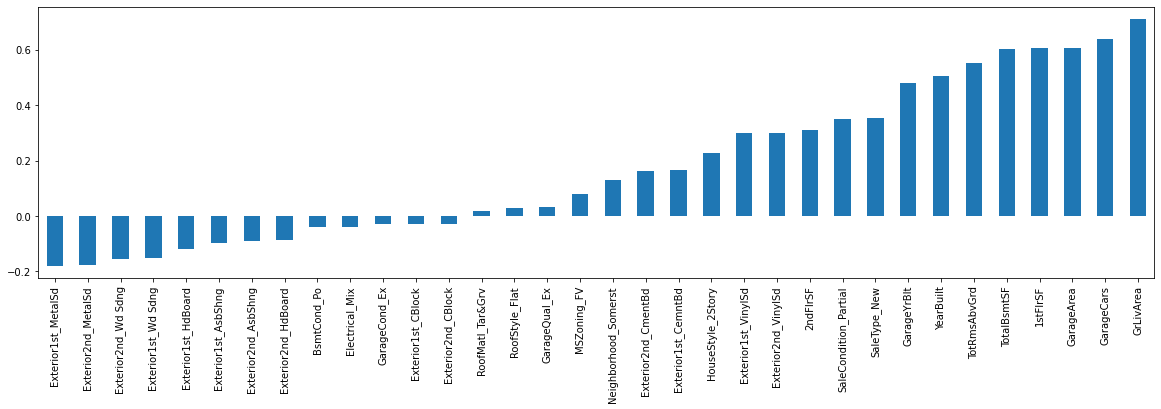

In [13]:
plt.figure(figsize=(20,5))
corr_matrix.SalePrice[cols_to_drop].sort_values().plot.bar();



---

After short analysis of table and plot above we can create a final list of cols to drop by removing from it:
* `GarageYrBlt`
* `1stFlrSF`
* `HouseStyle_2Story`
* `TotRmsAbvGrd`
* `GarageArea`
* `MSZoning_FV`
* `RoofMatl_Tar&Grv`
* `Exterior2nd_AsbShng`
* `Exterior2nd_CBlock`
* `Exterior2nd_CmentBd`
* `Exterior2nd_HdBoard`
* `Exterior2nd_MetalSd`
* `Exterior2nd_VinylSd`
* `Exterior1nd_Wd Sdng`
* `Electrical_Mix`
* `GarageCond_Ex`
* `SaleCondition_Partial`

---



In [14]:
cols_to_remove = ['GarageYrBlt', '1stFlrSF', 'HouseStyle_2Story', 'TotRmsAbvGrd', 'GarageArea', 'MSZoning_FV', 'RoofMatl_Tar&Grv',
                  'Exterior2nd_AsbShng', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_MetalSd',
                  'Exterior2nd_VinylSd', 'Exterior1st_Wd Sdng', 'Electrical_Mix', 'GarageCond_Ex', 'SaleCondition_Partial']
cols_to_drop = [i for i in cols_to_drop if i not in cols_to_remove]

df_dummies = df_dummies.drop(columns=cols_to_drop)
print('df_dummies.shape: ', df_dummies.shape)
df_dummies.head()

df_dummies.shape:  (1338, 249)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,...,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,196,706,0,150,856,0,1,0,2,1,3,1,8,0,2003,548,0,61,0,0,0,0,0,2,2008,208500,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,0,978,0,284,1262,0,0,1,2,0,3,1,6,1,1976,460,298,0,0,0,0,0,0,5,2007,181500,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2002,162,486,0,434,920,0,1,0,2,1,3,1,6,1,2001,608,0,42,0,0,0,0,0,9,2008,223500,0,0,0,1,0,0,1,1,...,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1970,0,216,0,540,961,0,1,0,1,0,3,1,7,1,1998,642,0,35,272,0,0,0,0,2,2006,140000,0,0,0,1,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,350,655,0,490,1145,0,1,0,2,1,4,1,9,1,2000,836,192,84,0,0,0,0,0,12,2008,250000,0,0,0,1,0,0,1,1,...,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0


### Feature Selection: Random Forest


For feature selection we will use one of the embedded methods called **SelectFromModel** which performs feature selection by using feature ranks generated by ML model and then prune the features based on that ranking.

As model used for this purpose we will use **RandomForestRegressor** which feature importance will be converted into feature subselection.

---

But firstly we need to define our feature matrix X and target vertor y.

**Note:** for purpsose of feature selection we need just to get the feature importances out of the model and don't really need to evaluate model's performance. That's why we can skip the step of dividing the dataset on train/test sets (which we will do later while modeling).

---

In [16]:
y = df_dummies['SalePrice']
X = df_dummies.drop(columns=['SalePrice'])
print('X.shape: ', X.shape, '\ny.shape: ', y.shape)
X.head()

X.shape:  (1338, 248) 
y.shape:  (1338,)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,...,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,196,706,0,150,856,0,1,0,2,1,3,1,8,0,2003,548,0,61,0,0,0,0,0,2,2008,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,0,978,0,284,1262,0,0,1,2,0,3,1,6,1,1976,460,298,0,0,0,0,0,0,5,2007,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2002,162,486,0,434,920,0,1,0,2,1,3,1,6,1,2001,608,0,42,0,0,0,0,0,9,2008,0,0,0,1,0,0,1,1,0,...,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1970,0,216,0,540,961,0,1,0,1,0,3,1,7,1,1998,642,0,35,272,0,0,0,0,2,2006,0,0,0,1,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,350,655,0,490,1145,0,1,0,2,1,4,1,9,1,2000,836,192,84,0,0,0,0,0,12,2008,0,0,0,1,0,0,1,1,0,...,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0




---

For defining optimal value for `max_depth` parameter of RandomForestRegressor we will use **GridSearchCV**.

---



In [17]:
t1 = time.time() # used for counting how long time GridSearchCV takes
gs = GridSearchCV(estimator=RandomForestRegressor(), param_grid={'max_depth':list(range(1, 21,))}, cv=10)
gs.fit(X, y)
t2 = time.time() # used for counting how long time GridSearchCV takes
print('Time: {:.3f}min'.format((t2-t1)/60)) # count how long time GridSearchCV takes
print('Best score: ', gs.best_score_, '\nBest params: ', gs.best_params_)

Time: 5.619min
Best score:  0.8342552795268672 
Best params:  {'max_depth': 14}


---

After finding the best possible value of `max_depth` parameter we can use the particular estimator as estimator for feature selection model.

---

In [18]:
#feature selection by converting feature importance into subset of features
sfm_model = SelectFromModel(gs.best_estimator_) # use model with best parameter as estimator
sfm_model.fit(X, y)
X = X.loc[:, X.columns[sfm_model.get_support()]] #prune features
print('X.shape: ', X.shape)
X.head()

X.shape:  (1338, 20)


,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,1stFlrSF,FullBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,Neighborhood_NoRidge,GarageType_Detchd
0,65.0,8450,7,5,2003,196,706,150,856,2,3,8,0,2003,548,0,61,2,0,0
1,80.0,9600,6,8,1976,0,978,284,1262,2,3,6,1,1976,460,298,0,5,0,0
2,68.0,11250,7,5,2002,162,486,434,920,2,3,6,1,2001,608,0,42,9,0,0
3,60.0,9550,7,5,1970,0,216,540,961,1,3,7,1,1998,642,0,35,2,0,1
4,84.0,14260,8,5,2000,350,655,490,1145,2,4,9,1,2000,836,192,84,12,1,0




---

By the end of our feature selection section let's doublecheck choosen features for multicollinearity.

---



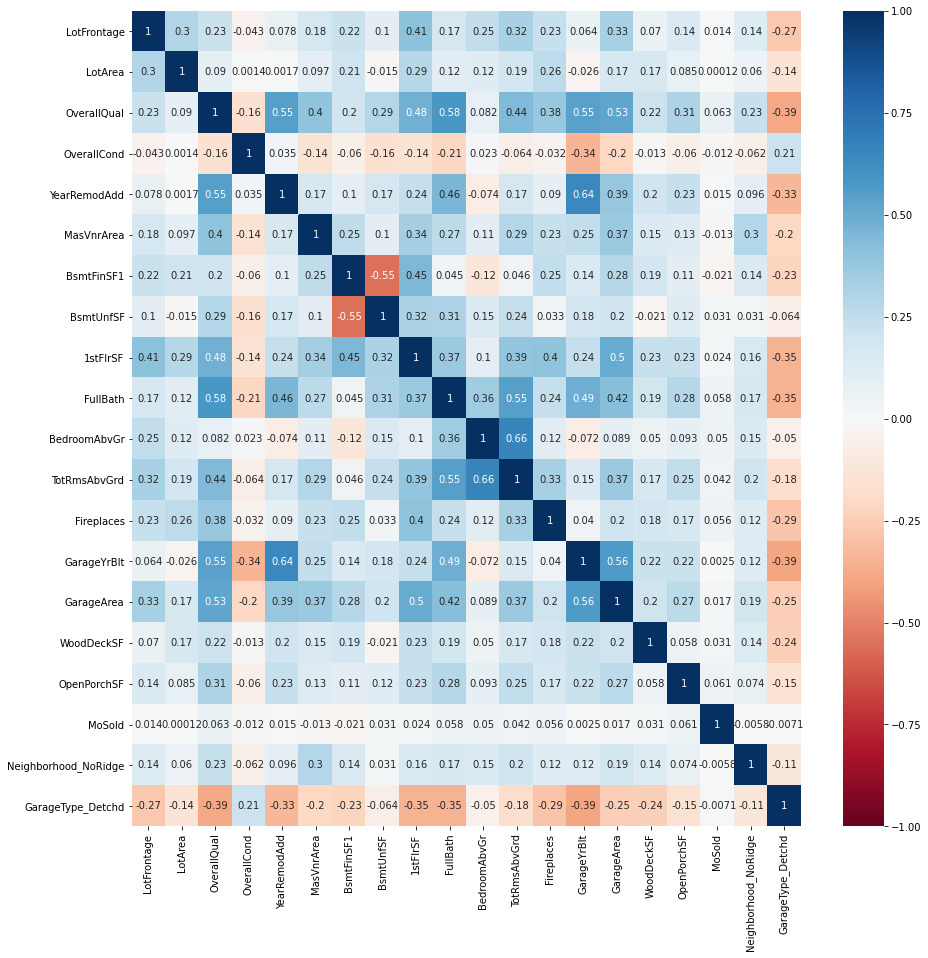

In [19]:
plt.figure(figsize=(15,15))
sns.heatmap(X.corr(), cmap='RdBu', vmax=1, vmin=-1, annot=True);



---

Let's have a look on remaining columns. 

---



In [20]:
X.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', '1stFlrSF', 'FullBath',
       'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'MoSold',
       'Neighborhood_NoRidge', 'GarageType_Detchd'],
      dtype='object')



---

As we can see 2 of dummies columns is in this list. So we will keep both of categorical columns for further modeling: `Neighborhood`, `GarageType`.

---

As we know we need the same set of feature in our test data to get prediction after we create a model. That's why let's create a function for pruning feature set (not to do it manually several times).

---



In [31]:
def prune_feat_set(df):
  cols_to_keep = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd',
                  'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', '1stFlrSF', 'FullBath',
                  'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
                  'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'MoSold',
                  'Neighborhood', 'GarageType']
  df = df[cols_to_keep]
  return df

# Feature Matrix & Target Vector Arrangement


So after we've made feature selection for future model we have all we need to arrange feature matrix and target vector. Let's difine them and check what kind of data (data type) we have in our feature matrix.

---



In [32]:
y = df['SalePrice']
X = prune_feat_set(df)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=42)
print('X_train.shape: ', X_train.shape, '\nX_test.shape: ', X_test.shape, '\n\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

X_train.shape:  (1003, 20) 
X_test.shape:  (335, 20) 

Y_train:  (1003,) 
Y_test:  (335,)


In [33]:
# check data types of feature matrix
X.dtypes

LotFrontage     float64
LotArea           int64
OverallQual       int64
OverallCond       int64
YearRemodAdd      int64
MasVnrArea        int64
BsmtFinSF1        int64
BsmtUnfSF         int64
1stFlrSF          int64
FullBath          int64
BedroomAbvGr      int64
TotRmsAbvGrd      int64
Fireplaces        int64
GarageYrBlt       int64
GarageArea        int64
WoodDeckSF        int64
OpenPorchSF       int64
MoSold            int64
Neighborhood     object
GarageType       object
dtype: object

# Pipeline



In a typical ML workflow we need to apply data transformations at least twice. Once when training the model and again on any new data we want to predict on. Of course we could write a function to apply them and reuse that but we would still need to run this first and then call the model separately. We will use **Pipeline** to simplify this process:
* they make our workflow much easier to read and understand
* they enforce the implementation and order of steps in your project
* these in turn make your work much more reproducible

---

As we know we have mixed data types in our data: numerical & categorical. These two groups of features should be dealt with differently. That's why we will:
* define numerical and categorical groups of features
* create 2 pipeline to deal with each of groups
  * as 1st step of each pipeline we will use **SimpleImputer** which is completing missing values:
    * *numerical data*: using the mean along each column
    * *categorical data*: replace missing values with fill_value = 'missing'
  * 2nd step is different for each of the pipeline:
    * *numerical data*: standartize data with **StandartScaler**
    * *categorical data*: encode data with **OneHotEncoder**

**Note:** 
* standartization is not really needed for tree-based models, but as long as we will compare results of different kinds of algorithms it's better to standartize data
* the main advantage of OneHotEncoder over pd.get_dummies it that it applies the same encoder we created via `X_train` to the new data set `X_test`. Let's imagine we need to encode `color` column with `red` and `green` values and new data will consist `blue`:
  * *pd.get_dummies*: will create a new columns `color_blue` which is gonna be useless for the model trained on `color_red` and `color_green`
  * *OneHotEncoder*: will set both of columns (`color_red` and `color_green`) to zeros and can be used in the model trained on these features

---




---

When you need to convert your data twice or more, you can write a func, but then you will have apply the func and then the model. Pipeline makes this action easier:
* They make your workflow much easier to read and understand.
* They enforce the implementation and order of steps in your project.
* These in turn make your work much more reproducible.

`pipeline = Pipeline(steps=[('name', model_to_apply)])`: create a pipeline with certain steps

`pipeline.fit(X, y)`: fit the model

`pipeline.named_steps['name']`: return just the step with certain name




---



In [24]:
#define num type cols
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
#define num type colsnumerical
cat_cols = X.select_dtypes(include=['object']).columns

In [25]:
# pipeline for num cols
num_transformer = Pipeline(steps=[
                                  ('imputer', SimpleImputer(strategy='mean')), # fill NaN with mean of the col
                                  ('scaler', StandardScaler()) # standartize data
                                  ])

#pipeline for cat cols
cat_transformer = Pipeline(steps=[
                                  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # fill NaN with 'missing' value
                                  ('onehot', OneHotEncoder(handle_unknown='ignore')) # encode cat data 
                                  ])



---

Next we need to connect each kind of column groups to pipeline created for it. For this purpose we will use **ColumnTransformer** which applies transformers to columns of DataFrame.

---





---

`preprocessor = ColumnTransformer(transformers=[('name', transformation_func, cols_to_apply)]`: Applies transformers to columns of an array or pandas DataFrame

`preprocessor.transformers_[0]`: show 1st transformer
`preprocessor.transformers_[0][1]`: return transformation_func

`preprocessor.fit_transform(X, y=None).toarray()`: Fit all transformers, transform the data and concatenate results <-- sparse matrix, toaaray to get numpy array

`pd.DataFrame(result.toarray())`: convert result of transformation into df

---





In [26]:
preprocessor = ColumnTransformer(transformers=[
                                              ('num', num_transformer, num_cols), # connect num cols to num pipeline
                                              ('cat', cat_transformer, cat_cols) # coonect cat cols to cat pipeline
                                              ])

# Model Choice


With next step we need to choose ML model we want to use for making the prediction. In production system we often have some requirements that force us to choose one algorithm over another. But as long as goal of this project is to get the best prediction possible, we will just compare performance of different models:

* **LinearRegression**
* **DecisionTreeRegressor**
* **RandomForestRegressor**
* **GradientBoostingRegressor**
* **XGBRegressor**

---

In [38]:
models = [LinearRegression(),
          DecisionTreeRegressor(random_state=41),
          RandomForestRegressor(random_state=41),
          GradientBoostingRegressor(random_state=41),
          XGBRegressor(random_state=41)]

for model in models:
  pipe = Pipeline(steps=[
                         ('preprocessor', preprocessor),
                         ('model', model)
                         ])
  pipe.fit(X_train, Y_train)
  print(type(model).__name__) #print just the name of the model
  print("Model score: {:.3f}\n".format(pipe.score(X_test, Y_test)))

LinearRegression
Model score: 0.762

DecisionTreeRegressor
Model score: 0.513

RandomForestRegressor
Model score: 0.737

GradientBoostingRegressor
Model score: 0.710

[04:04:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor
Model score: 0.724





---

As we can see on basic (with no hyperparameters tuning) model we are getting best score (R-squared) with RandomForestRegressor. Let's keep this model as the one for prediction. But before it let's find the best performance parameters.

---



# Tuning hyperparameters


For this purpose we will use **GridSearchCV** algorithm and tune following parameters of our model:
* `max_depth`
* `n_estimator`
* `criterion`
* `max_features`

---



In [39]:
t1 = time.time() # to count how long the GridSearchCV took

# parameters we want to turn with possible values
param_grid = {'regressor__max_depth':list(range(1, 21, 4)),
              'regressor__n_estimators':[100, 200, 500],
              'regressor__criterion':['mse', 'mae'],
              'regressor__max_features':['auto', 'sqrt', 'log2']}

# pipeline with particular model
rf = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', RandomForestRegressor(random_state=41))
                     ])

gs = GridSearchCV(rf, param_grid, cv=10)
gs.fit(X_train, Y_train)

t2 = time.time()# to count how long the GridSearchCV took
print('Time: {:.3f} min'.format((t2-t1)/60)) #print how much time GridSearchCV took
print('Best score: {:.3f}', gs.best_score_, '\nBest params: ', gs.best_params_) #print score and parameters of best estimator

Time: 49.000 min
Best score: {:.3f} 0.834412001765392 
Best params:  {'regressor__criterion': 'mse', 'regressor__max_depth': 17, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 500}




---

Finally when we know the best performance paramenters of our model. Let's create, train and evaluate our model.

---



In [40]:
#create the model
rf = Pipeline(steps=[('preprocessor', preprocessor),
                     ('regressor', RandomForestRegressor(n_estimators=500,
                                                         max_depth=17,
                                                         max_features='sqrt',
                                                         criterion='mse'))
                     ])
#train the model
rf.fit(X_train, Y_train)
#evaluate performance of the model
rf.score(X_test, Y_test)

0.7736342325016092

# Test Data


As final step we will use the model we trained on new data. For this we will:
* load data
* prune the feature set by applying prune_feat_set function
* using trained model for getting the prediction

---



In [41]:
df_test = pd.read_csv('https://raw.githubusercontent.com/pe44enka/HousePriceChallendge/master/data/Housing_test.csv')
print('df_test.shape: ', df_test.shape)
df_test.head()

df_test.shape:  (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [42]:
#cols_to_keep.remove('SalePrice')
X_test = prune_feat_set(df_test)
print('X_test.shape: ', X_test.shape)
X_test.head()

X_test.shape:  (1459, 20)


,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,1stFlrSF,FullBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,Neighborhood,GarageType
0,80.0,11622,5,6,1961,0.0,468.0,270.0,896,1,2,5,0,1961.0,730.0,140,0,6,NAmes,Attchd
1,81.0,14267,6,6,1958,108.0,923.0,406.0,1329,1,3,6,0,1958.0,312.0,393,36,6,NAmes,Attchd
2,74.0,13830,5,5,1998,0.0,791.0,137.0,928,2,3,6,1,1997.0,482.0,212,34,3,Gilbert,Attchd
3,78.0,9978,6,6,1998,20.0,602.0,324.0,926,2,3,7,1,1998.0,470.0,360,36,6,Gilbert,Attchd
4,43.0,5005,8,5,1992,0.0,263.0,1017.0,1280,2,2,5,0,1992.0,506.0,0,82,1,StoneBr,Attchd


In [43]:
result = df_test[['Id']]
result['SalePrice'] = rf.predict(X_test)

print('result.shape: ', result.shape)
result.head()

result.shape:  (1459, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Id,SalePrice
0,1461,134519.571637
1,1462,155257.663824
2,1463,184830.608178
3,1464,187639.114805
4,1465,197813.278452


In [44]:
result.to_csv('SalePrice_result.csv')

# Data Preprocessing

### Data for LR

####Missing Data

In [ ]:
df[df.columns[df.isna().sum().values > 0]].isna().sum()

LotFrontage     259
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

In [ ]:
#drop categorical columns with more than 50% of missing values & features with distinct values (like id)
df.drop(columns=['Id', 'Alley', 'FireplaceQu','PoolQC', 'Fence', 'MiscFeature'], inplace=True)

#fill na of numerical columns with mean of the  particular column
df['LotFrontage'] = df.LotFrontage.fillna(df.LotFrontage.mean())
df['GarageYrBlt'] = df.GarageYrBlt.fillna(int(df.GarageYrBlt.mean())).astype(int)
df['MasVnrArea'] = df.MasVnrArea.fillna(int(df.MasVnrArea.mean())).astype(int)

#drop others missing values in categorical columns
df.dropna(inplace=True)

df.shape

(1460, 75)

In [ ]:
#check for NaN
df.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y = df.pop('SalePrice')
X = df
X = X.reset_index()
X.pop('index')
print(X.shape)
X.head()

(1338, 74)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal


#### Categorical Data

In [ ]:
cat_cols = X.columns[X.dtypes=='object'].tolist()
print(len(cat_cols))
cat_cols

38


['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [ ]:
X[cat_cols].nunique()

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      14
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         4
Foundation        5
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           4
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

In [ ]:
single_value_cols = X[cat_cols].columns[(X[cat_cols].nunique()==1).values].tolist()
len(single_value_cols)

0

In [ ]:
multi_value_cols = X[cat_cols].columns[(X[cat_cols].nunique()>1).values].tolist()
len(multi_value_cols)

38

In [ ]:
#get dummies on multiple cols categorical features
X = pd.get_dummies(X, columns=multi_value_cols, drop_first=True)
print(X.shape)
X.head()

(1338, 227)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,...,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003,2,548,0,61,0,0,0,0,0,2,2008,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976,2,460,298,0,0,0,0,0,0,5,2007,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001,2,608,0,42,0,0,0,0,0,9,2008,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998,3,642,0,35,272,0,0,0,0,2,2006,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000,3,836,192,84,0,0,0,0,0,12,2008,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


#### Standartization



---

**Warning:** no standartization for RandomForest and GradientBoostingMachine

---



In [ ]:
num_cols = X.columns[X.dtypes!='uint8'].tolist()
print(len(num_cols))
num_cols

36


['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [ ]:
#standartize data
std = StandardScaler()
X_std = pd.DataFrame(std.fit_transform(X[num_cols]), columns=num_cols)
print(X_std.shape)
X_std.head()

(1338, 36)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.093701,-0.254147,-0.218363,0.589337,-0.553402,1.014157,0.854216,0.461582,0.527157,-0.296255,-0.983421,-0.591875,-0.828516,1.128813,-0.10374,0.331321,1.088949,-0.250577,0.775560,1.184848,0.174239,-0.17119,0.915080,-1.005546,0.985427,0.202747,0.249341,-0.779554,0.202294,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319,0.146084
1,-0.876298,0.422953,-0.107067,-0.165963,2.230251,0.100528,-0.476562,-0.594820,1.120240,-0.296255,-0.678727,0.409598,0.221935,-0.811389,-0.10374,-0.529579,-0.851149,3.888586,0.775560,-0.799291,0.174239,-0.17119,-0.347165,0.544478,-0.104844,0.202747,-0.222023,1.557895,-0.731311,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,-0.493561,-0.605686
2,0.093701,-0.118727,0.052620,0.589337,-0.553402,0.946480,0.804928,0.278328,0.047458,-0.296255,-0.337652,-0.434007,-0.662928,1.156076,-0.10374,0.477367,1.088949,-0.250577,0.775560,1.184848,0.174239,-0.17119,-0.347165,0.544478,0.904666,0.202747,0.570726,-0.779554,-0.088501,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,0.988784,0.146084
3,0.336201,-0.479847,-0.111906,0.589337,-0.553402,-1.963596,-0.772291,-0.594820,-0.541263,-0.296255,-0.096626,-0.838543,-0.556848,0.906167,-0.10374,0.344773,1.088949,-0.250577,-1.051375,-0.799291,0.174239,-0.17119,0.283958,0.544478,0.783525,1.779928,0.752844,-0.779554,-0.195636,4.122511,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319,-1.357457
4,0.093701,0.603514,0.343926,1.344638,-0.553402,0.912642,0.706352,1.291612,0.415954,-0.296255,-0.210318,0.120996,-0.080781,1.580921,-0.10374,1.269088,1.088949,-0.250577,0.775560,1.184848,1.462256,-0.17119,1.546203,0.544478,0.864286,1.779928,1.791989,0.726453,0.554309,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,2.100542,0.146084


In [ ]:
X = X.drop(columns=num_cols)
X = X.merge(X_std, left_index=True, right_index=True, how='left')
print(X.shape)
X.head()

(1338, 227)


,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0.093701,-0.254147,-0.218363,0.589337,-0.553402,1.014157,0.854216,0.461582,0.527157,-0.296255,-0.983421,-0.591875,-0.828516,1.128813,-0.10374,0.331321,1.088949,-0.250577,0.775560,1.184848,0.174239,-0.17119,0.915080,-1.005546,0.985427,0.202747,0.249341,-0.779554,0.202294,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319,0.146084
1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,-0.876298,0.422953,-0.107067,-0.165963,2.230251,0.100528,-0.476562,-0.594820,1.120240,-0.296255,-0.678727,0.409598,0.221935,-0.811389,-0.10374,-0.529579,-0.851149,3.888586,0.775560,-0.799291,0.174239,-0.17119,-0.347165,0.544478,-0.104844,0.202747,-0.222023,1.557895,-0.731311,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,-0.493561,-0.605686
2,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0.093701,-0.118727,0.052620,0.589337,-0.553402,0.946480,0.804928,0.278328,0.047458,-0.296255,-0.337652,-0.434007,-0.662928,1.156076,-0.10374,0.477367,1.088949,-0.250577,0.775560,1.184848,0.174239,-0.17119,-0.347165,0.544478,0.904666,0.202747,0.570726,-0.779554,-0.088501,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,0.988784,0.146084
3,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.336201,-0.479847,-0.111906,0.589337,-0.553402,-1.963596,-0.772291,-0.594820,-0.541263,-0.296255,-0.096626,-0.838543,-0.556848,0.906167,-0.10374,0.344773,1.088949,-0.250577,-1.051375,-0.799291,0.174239,-0.17119,0.283958,0.544478,0.783525,1.779928,0.752844,-0.779554,-0.195636,4.122511,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319,-1.357457
4,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0.093701,0.603514,0.343926,1.344638,-0.553402,0.912642,0.706352,1.291612,0.415954,-0.296255,-0.210318,0.120996,-0.080781,1.580921,-0.10374,1.269088,1.088949,-0.250577,0.775560,1.184848,1.462256,-0.17119,1.546203,0.544478,0.864286,1.779928,1.791989,0.726453,0.554309,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,2.100542,0.146084


#### Feature Selection: Lasso Regression

In [ ]:
gs = GridSearchCV(estimator=Lasso(random_state=0), param_grid={'alpha':list(range(100, 1001, 50))}, cv=10)
gs.fit(X, y)
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.098685,0.009077,0.002649,0.000182,100,{'alpha': 100},0.908939,0.907172,0.904345,0.769465,0.880792,0.831490,0.877844,0.858652,0.417339,0.879121,0.823516,0.141192,5
1,0.063029,0.005541,0.002664,0.000349,150,{'alpha': 150},0.905526,0.907595,0.908158,0.769011,0.869502,0.854573,0.877320,0.862388,0.412388,0.881597,0.824806,0.142758,3
2,0.047671,0.002661,0.002561,0.000047,200,{'alpha': 200},0.905158,0.905785,0.910459,0.766014,0.862245,0.868495,0.875796,0.866002,0.413778,0.884317,0.825805,0.142790,1
3,0.039528,0.002712,0.002581,0.000038,250,{'alpha': 250},0.903839,0.901911,0.911812,0.762000,0.858660,0.872576,0.876111,0.869159,0.414978,0.884983,0.825603,0.142586,2
4,0.035817,0.003643,0.002573,0.000064,300,{'alpha': 300},0.900784,0.898597,0.912772,0.757610,0.855636,0.870078,0.876067,0.870946,0.416163,0.885058,0.824371,0.142072,4
5,0.029935,0.001674,0.002668,0.000412,350,{'alpha': 350},0.899831,0.896789,0.912860,0.753982,0.852125,0.867605,0.875312,0.870355,0.416201,0.884464,0.822952,0.141868,6
6,0.028758,0.003266,0.002586,0.000102,400,{'alpha': 400},0.898645,0.894712,0.912235,0.751968,0.848407,0.864823,0.874476,0.868263,0.407209,0.883842,0.820458,0.144044,7
7,0.025186,0.002068,0.002569,0.000041,450,{'alpha': 450},0.897092,0.892368,0.911102,0.749765,0.844465,0.861747,0.873207,0.865520,0.398560,0.882955,0.817678,0.146006,8
8,0.024768,0.002174,0.002573,0.000055,500,{'alpha': 500},0.894937,0.890079,0.909821,0.747470,0.840497,0.858286,0.872181,0.861884,0.390619,0.881301,0.814708,0.147670,9
9,0.022810,0.001377,0.002540,0.000036,550,{'alpha': 550},0.892350,0.887455,0.908685,0.745469,0.836289,0.854961,0.871107,0.857871,0.384039,0.879632,0.811786,0.148890,10


In [ ]:
print('Best score: ', gs.best_score_, '\nBest parameter: ', gs.best_params_)

Best score:  0.8258047792030409 
Best parameter:  {'alpha': 200}


In [ ]:
#feature selection by L1 regularization
sfm_model = SelectFromModel(gs.best_estimator_)
sfm_model.fit(X, y)
X = X.loc[:, X.columns[sfm_model.get_support()]]
#X_test = X_test.loc[:, X_test.columns[sfm_model.get_support()]]
print(X.shape)
X.head()

(1338, 86)


,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LandContour_HLS,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LandSlope_Mod,Neighborhood_BrkSide,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Somerst,Neighborhood_StoneBr,Condition1_Norm,Condition2_PosN,BldgType_2fmCon,HouseStyle_1Story,HouseStyle_2Story,RoofStyle_Gable,RoofStyle_Hip,RoofMatl_WdShngl,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Stucco,Exterior2nd_Plywood,Exterior2nd_Stucco,MasVnrType_BrkFace,MasVnrType_None,ExterQual_Gd,ExterQual_TA,Foundation_PConc,...,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_Unf,HeatingQC_Gd,HeatingQC_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Typ,GarageFinish_RFn,GarageQual_Fa,PavedDrive_Y,SaleType_New,SaleCondition_Normal,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,...,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0.093701,-0.254147,-0.218363,0.589337,-0.553402,1.014157,0.854216,0.461582,0.527157,1.128813,-0.10374,0.331321,1.088949,-0.250577,0.775560,0.174239,-0.17119,0.915080,-1.005546,0.202747,-0.779554,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319
1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,1,1,0,1,0,1,-0.876298,0.422953,-0.107067,-0.165963,2.230251,0.100528,-0.476562,-0.594820,1.120240,-0.811389,-0.10374,-0.529579,-0.851149,3.888586,0.775560,0.174239,-0.17119,-0.347165,0.544478,0.202747,1.557895,-0.118688,-0.283203,-0.071771,-0.084535,-0.493561
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,...,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0.093701,-0.118727,0.052620,0.589337,-0.553402,0.946480,0.804928,0.278328,0.047458,1.156076,-0.10374,0.477367,1.088949,-0.250577,0.775560,0.174239,-0.17119,-0.347165,0.544478,0.202747,-0.779554,-0.118688,-0.283203,-0.071771,-0.084535,0.988784
3,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0.336201,-0.479847,-0.111906,0.589337,-0.553402,-1.963596,-0.772291,-0.594820,-0.541263,0.906167,-0.10374,0.344773,1.088949,-0.250577,-1.051375,0.174239,-0.17119,0.283958,0.544478,1.779928,-0.779554,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319
4,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,...,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0.093701,0.603514,0.343926,1.344638,-0.553402,0.912642,0.706352,1.291612,0.415954,1.580921,-0.10374,1.269088,1.088949,-0.250577,0.775560,1.462256,-0.17119,1.546203,0.544478,1.779928,0.726453,-0.118688,-0.283203,-0.071771,-0.084535,2.100542


#### Multicollinearity

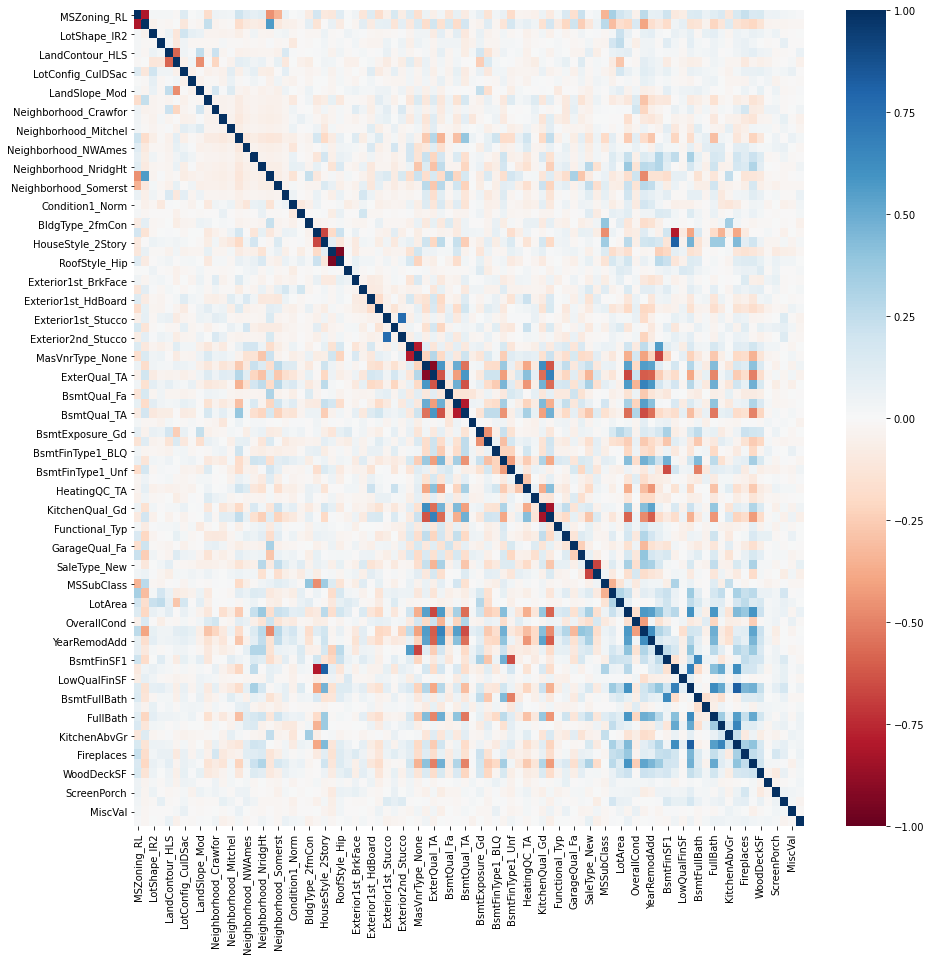

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(X.corr(), cmap='RdBu', vmax=1, vmin=-1)

In [ ]:
corr_matrix = X.corr()
columns = corr_matrix.columns

corr_matrix.reset_index(inplace=True)
corr_matrix = corr_matrix.melt(id_vars='index', value_vars=columns)
print(corr_matrix.shape)
corr_matrix.head()

(7396, 3)


,index,variable,value
0,MSZoning_RL,MSZoning_RL,1.000000
1,MSZoning_RM,MSZoning_RL,-0.807847
2,LotShape_IR2,MSZoning_RL,0.023244
3,LotShape_IR3,MSZoning_RL,0.022271
4,LandContour_HLS,MSZoning_RL,0.017553


In [ ]:
corr_matrix = corr_matrix[corr_matrix.value!=1]
cols_to_drop = corr_matrix[corr_matrix.value > .8]['index'].tolist()
X = X.drop(columns=cols_to_drop)
print(X.shape)
X.head()

(1338, 82)


,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LandContour_HLS,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LandSlope_Mod,Neighborhood_BrkSide,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Somerst,Neighborhood_StoneBr,Condition1_Norm,Condition2_PosN,BldgType_2fmCon,HouseStyle_1Story,RoofStyle_Gable,RoofStyle_Hip,RoofMatl_WdShngl,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Stucco,Exterior2nd_Plywood,Exterior2nd_Stucco,MasVnrType_BrkFace,MasVnrType_None,ExterQual_Gd,ExterQual_TA,Foundation_PConc,BsmtQual_Fa,...,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_Unf,HeatingQC_Gd,HeatingQC_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Typ,GarageFinish_RFn,GarageQual_Fa,PavedDrive_Y,SaleType_New,SaleCondition_Normal,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,...,1,0,1,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0.093701,-0.254147,-0.218363,0.589337,-0.553402,1.014157,0.854216,0.461582,0.527157,-0.10374,1.088949,-0.250577,0.775560,0.174239,-0.17119,-1.005546,0.202747,-0.779554,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319
1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,1,-0.876298,0.422953,-0.107067,-0.165963,2.230251,0.100528,-0.476562,-0.594820,1.120240,-0.10374,-0.851149,3.888586,0.775560,0.174239,-0.17119,0.544478,0.202747,1.557895,-0.118688,-0.283203,-0.071771,-0.084535,-0.493561
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0.093701,-0.118727,0.052620,0.589337,-0.553402,0.946480,0.804928,0.278328,0.047458,-0.10374,1.088949,-0.250577,0.775560,0.174239,-0.17119,0.544478,0.202747,-0.779554,-0.118688,-0.283203,-0.071771,-0.084535,0.988784
3,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0.336201,-0.479847,-0.111906,0.589337,-0.553402,-1.963596,-0.772291,-0.594820,-0.541263,-0.10374,1.088949,-0.250577,-1.051375,0.174239,-0.17119,0.544478,1.779928,-0.779554,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319
4,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0.093701,0.603514,0.343926,1.344638,-0.553402,0.912642,0.706352,1.291612,0.415954,-0.10374,1.088949,-0.250577,0.775560,1.462256,-0.17119,0.544478,1.779928,0.726453,-0.118688,-0.283203,-0.071771,-0.084535,2.100542


#### train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25)
print(X_train.shape, X_test.shape)

(1003, 82) (335, 82)


### Data for RF & GBM

####Missing Data

In [ ]:
df[df.columns[df.isna().sum().values > 0]].isna().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [ ]:
#drop categorical columns with more than 50% of missing values & constant features (like id)
df.drop(columns=['Id', 'Alley', 'FireplaceQu','PoolQC', 'Fence', 'MiscFeature'], inplace=True)

#fill na of numerical columns with mean of the  particular column
df['LotFrontage'] = df.LotFrontage.fillna(df.LotFrontage.mean())
df['GarageYrBlt'] = df.GarageYrBlt.fillna(int(df.GarageYrBlt.mean())).astype(int)
df['MasVnrArea'] = df.MasVnrArea.fillna(int(df.MasVnrArea.mean())).astype(int)

#drop others missing values in categorical columns
df.dropna(inplace=True)

df.shape

(1338, 75)

In [ ]:
#check for NaN
df.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y = df.pop('SalePrice')
X = df
X = X.reset_index()
X.pop('index')
print(X.shape)
X.head()

(1338, 74)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal


#### Categorical Data

In [ ]:
cat_cols = X.columns[X.dtypes=='object'].tolist()
print(len(cat_cols))
cat_cols

38


['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [ ]:
X[cat_cols].nunique()

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      14
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         4
Foundation        5
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           4
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

In [ ]:
single_value_cols = X[cat_cols].columns[(X[cat_cols].nunique()==1).values].tolist()
len(single_value_cols)

0

In [ ]:
multi_value_cols = X[cat_cols].columns[(X[cat_cols].nunique()>1).values].tolist()
len(multi_value_cols)

38

In [ ]:
#get dummies on multiple cols categorical features
X = pd.get_dummies(X, columns=multi_value_cols, drop_first=False)
print(X.shape)
X.head()

(1338, 265)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,...,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003,2,548,0,61,0,0,0,0,0,2,2008,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976,2,460,298,0,0,0,0,0,0,5,2007,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001,2,608,0,42,0,0,0,0,0,9,2008,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998,3,642,0,35,272,0,0,0,0,2,2006,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000,3,836,192,84,0,0,0,0,0,12,2008,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


#### Feature Selection: Random Forest

In [ ]:
gs = GridSearchCV(estimator=RandomForestRegressor(n_estimators=100, bootstrap=True, oob_score=True), param_grid={'max_depth':list(range(1, 21,))}, cv=10)
gs.fit(X, y)
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.348395,0.007595,0.009715,0.001242,1,{'max_depth': 1},0.363816,0.464915,0.490598,0.493360,0.536089,0.464446,0.476106,0.444693,0.448731,0.460020,0.464277,0.041919,20
1,0.501127,0.006800,0.010412,0.002138,2,{'max_depth': 2},0.598238,0.669834,0.729251,0.642800,0.697427,0.634646,0.659448,0.667964,0.628453,0.681106,0.660917,0.035415,19
2,0.654977,0.004633,0.009507,0.000616,3,{'max_depth': 3},0.714092,0.748693,0.819349,0.705385,0.780276,0.738207,0.746933,0.780983,0.673670,0.762782,0.747037,0.040022,18
3,0.823210,0.003149,0.009752,0.000162,4,{'max_depth': 4},0.772669,0.812381,0.873060,0.743742,0.822295,0.805745,0.793798,0.839054,0.720481,0.803271,0.798650,0.042205,17
4,0.994553,0.007371,0.009773,0.000158,5,{'max_depth': 5},0.813036,0.835335,0.889757,0.750207,0.848308,0.836989,0.834994,0.857852,0.735352,0.830676,0.823251,0.044657,16
5,1.177817,0.004450,0.010171,0.000199,6,{'max_depth': 6},0.820084,0.852591,0.904249,0.737854,0.861483,0.863632,0.866884,0.879402,0.777894,0.849035,0.841311,0.047259,15
6,1.375772,0.007643,0.010319,0.000177,7,{'max_depth': 7},0.844025,0.863396,0.907082,0.747267,0.864586,0.873231,0.868533,0.890933,0.728921,0.858734,0.844671,0.055903,14
7,1.582672,0.005525,0.010731,0.000224,8,{'max_depth': 8},0.849381,0.870294,0.912143,0.760489,0.873654,0.878283,0.870968,0.892972,0.725914,0.858678,0.849278,0.056035,13
8,1.785254,0.007553,0.011232,0.000816,9,{'max_depth': 9},0.843591,0.862403,0.910049,0.756316,0.869762,0.866100,0.886418,0.901191,0.790421,0.861288,0.854754,0.045415,9
9,1.981203,0.010628,0.011731,0.001260,10,{'max_depth': 10},0.853211,0.867875,0.910466,0.759404,0.874641,0.879249,0.884609,0.895955,0.752116,0.859025,0.853655,0.051473,12


In [ ]:
print('Best score: ', gs.best_score_, '\nBest parameter: ', gs.best_params_)

Best score:  0.8584246869060669 
Best parameter:  {'max_depth': 12}


In [ ]:
#feature selection by L1 regularization
sfm_model = SelectFromModel(gs.best_estimator_)
sfm_model.fit(X, y)
X = X.loc[:, X.columns[sfm_model.get_support()]]
#X_test = X_test.loc[:, X_test.columns[sfm_model.get_support()]]
print(X.shape)
X.head()

(1338, 20)


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold
0,65.0,8450,7,5,2003,2003,706,150,856,856,854,1710,2,8,2003,2,548,0,61,2
1,80.0,9600,6,8,1976,1976,978,284,1262,1262,0,1262,2,6,1976,2,460,298,0,5
2,68.0,11250,7,5,2001,2002,486,434,920,920,866,1786,2,6,2001,2,608,0,42,9
3,60.0,9550,7,5,1915,1970,216,540,756,961,756,1717,1,7,1998,3,642,0,35,2
4,84.0,14260,8,5,2000,2000,655,490,1145,1145,1053,2198,2,9,2000,3,836,192,84,12


#### Multicollinearity

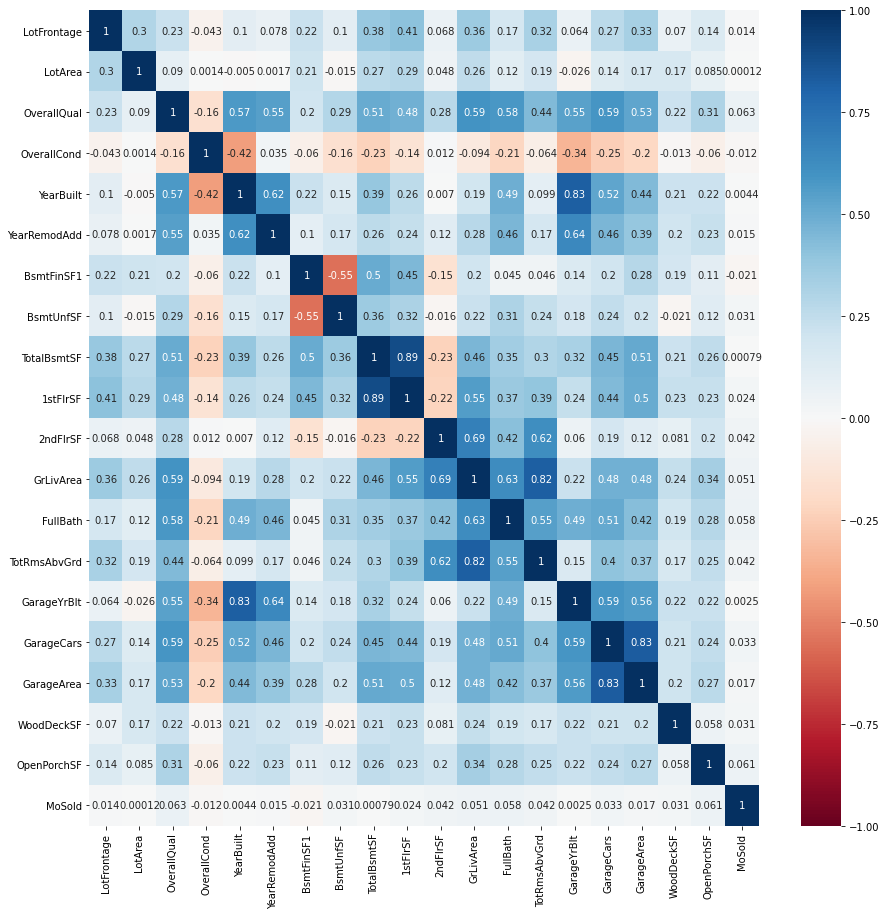

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(X.corr(), cmap='RdBu', vmax=1, vmin=-1, annot=True)

In [ ]:
corr_matrix = X.corr()
columns = corr_matrix.columns

corr_matrix.reset_index(inplace=True)
corr_matrix = corr_matrix.melt(id_vars='index', value_vars=columns)
print(corr_matrix.shape)
corr_matrix.head()

(400, 3)


,index,variable,value
0,LotFrontage,LotFrontage,1.000000
1,LotArea,LotFrontage,0.300018
2,OverallQual,LotFrontage,0.225559
3,OverallCond,LotFrontage,-0.042652
4,YearBuilt,LotFrontage,0.102425


In [ ]:
corr_matrix = corr_matrix[corr_matrix.value!=1]
cols_to_drop = corr_matrix[corr_matrix.value > .8]['index'].tolist()
X = X.drop(columns=cols_to_drop)
print(X.shape)
X.head()

(1338, 12)


,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,2ndFlrSF,FullBath,WoodDeckSF,OpenPorchSF,MoSold
0,65.0,8450,7,5,2003,706,150,854,2,0,61,2
1,80.0,9600,6,8,1976,978,284,0,2,298,0,5
2,68.0,11250,7,5,2002,486,434,866,2,0,42,9
3,60.0,9550,7,5,1970,216,540,756,1,0,35,2
4,84.0,14260,8,5,2000,655,490,1053,2,192,84,12


#### train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25)
print(X_train.shape, X_test.shape)

(1003, 12) (335, 12)


## LinearRegression

### statsmodel

In [ ]:
#LR model
Y_train_sm = list(Y_train)
X_train_sm = sm.add_constant(X_train)
lr_model = sm.OLS(Y_train_sm, X_train_sm)
result = lr_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     89.06
Date:                Wed, 15 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:22:18   Log-Likelihood:                -11635.
No. Observations:                1003   AIC:                         2.344e+04
Df Residuals:                     920   BIC:                         2.384e+04
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.115e+05 

### LinearRegression Model and Evaluation

In [ ]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
lr.score(X_test, Y_test)

0.7116413789459229

## Random Forest

In [ ]:
rf_gs = GridSearchCV(estimator=RandomForestRegressor(n_estimators=100, bootstrap=True, oob_score=True), param_grid={'max_depth':list(range(1, 21,))}, cv=10)
rf_gs.fit(X_train, Y_train)
pd.DataFrame(rf_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.193510,0.009040,0.008741,0.000227,1,{'max_depth': 1},0.322609,0.451674,0.482073,0.469671,0.525759,0.626163,0.409634,0.428585,0.313119,0.600634,0.462992,0.098105,20
1,0.218961,0.003511,0.008666,0.000236,2,{'max_depth': 2},0.542859,0.590601,0.652426,0.614329,0.689501,0.700516,0.596762,0.676993,0.492458,0.722671,0.627912,0.070130,19
2,0.247635,0.003273,0.009069,0.000374,3,{'max_depth': 3},0.693162,0.707015,0.722344,0.705385,0.773662,0.757536,0.652399,0.763668,0.503620,0.783974,0.706276,0.078040,18
3,0.275785,0.003489,0.009410,0.000779,4,{'max_depth': 4},0.757887,0.752840,0.759749,0.756613,0.826477,0.781275,0.708006,0.802583,0.474489,0.830652,0.745057,0.096815,17
4,0.303221,0.003418,0.009184,0.000161,5,{'max_depth': 5},0.790549,0.772882,0.790359,0.789023,0.848066,0.810695,0.732956,0.837499,0.467579,0.851092,0.769070,0.106260,16
5,0.333163,0.004392,0.009308,0.000209,6,{'max_depth': 6},0.790268,0.793592,0.796102,0.804519,0.857571,0.826498,0.752135,0.857339,0.501222,0.867699,0.784695,0.100636,14
6,0.360218,0.004234,0.009789,0.000887,7,{'max_depth': 7},0.793524,0.799299,0.797329,0.807716,0.855020,0.832300,0.764364,0.862766,0.448202,0.879188,0.783971,0.116984,15
7,0.389137,0.002702,0.009951,0.000479,8,{'max_depth': 8},0.810221,0.804244,0.802919,0.827630,0.859017,0.830332,0.763374,0.876348,0.501610,0.879839,0.795554,0.103770,8
8,0.415441,0.002768,0.010005,0.000233,9,{'max_depth': 9},0.814221,0.794593,0.812275,0.827707,0.853546,0.835258,0.786933,0.877514,0.487371,0.886732,0.797615,0.108001,2
9,0.442479,0.003066,0.010279,0.000121,10,{'max_depth': 10},0.799390,0.811054,0.804448,0.824015,0.852545,0.836956,0.779720,0.873776,0.498566,0.877222,0.795769,0.103608,5


In [ ]:
print('Best score: ', rf_gs.best_score_, '\nBest parameter: ', rf_gs.best_params_)

Best score:  0.7990153117068203 
Best parameter:  {'max_depth': 14}


In [ ]:
rfr = rf_gs.best_estimator_
rfr.fit(X_train, Y_train)
print('Accuracy of training set: ', rfr.score(X_train, Y_train))
print('Accuracy of test set: ', rfr.score(X_test, Y_test))

Accuracy of training set:  0.9734610287049261
Accuracy of test set:  0.7793002391000122


## Gradient Boosting Machine

In [ ]:
gbm_gs = GridSearchCV(estimator=GradientBoostingRegressor(random_state=0), param_grid={'max_depth' : list(range(1,20))+[None], 'learning_rate':list(np.arange(0.01, 1, 0.1))}, cv=10)
gbm_gs.fit(X_train, Y_train)
pd.DataFrame(gbm_gs.cv_results_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'NoneType' and 'float'

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'NoneType' and 'float'

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'NoneType' and 'float'

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.p

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.085642,0.004906,0.001839,0.000156,0.01,1,"{'learning_rate': 0.01, 'max_depth': 1}",0.303686,0.475570,0.440852,0.520310,0.484794,0.478679,0.428827,0.378838,0.429692,0.494052,0.443530,0.060472,200
1,0.133352,0.005483,0.002030,0.000376,0.01,2,"{'learning_rate': 0.01, 'max_depth': 2}",0.454992,0.570813,0.541771,0.608662,0.590440,0.567018,0.530261,0.611093,0.524531,0.574051,0.557363,0.044385,199
2,0.176106,0.001534,0.001926,0.000056,0.01,3,"{'learning_rate': 0.01, 'max_depth': 3}",0.557520,0.620966,0.575197,0.663520,0.650161,0.605214,0.584507,0.686108,0.565196,0.626822,0.613521,0.041466,198
3,0.223292,0.003883,0.002008,0.000048,0.01,4,"{'learning_rate': 0.01, 'max_depth': 4}",0.611691,0.645927,0.621184,0.698280,0.685500,0.633493,0.619848,0.726501,0.517205,0.670550,0.643018,0.055235,185
4,0.268499,0.005900,0.002109,0.000032,0.01,5,"{'learning_rate': 0.01, 'max_depth': 5}",0.643623,0.667145,0.646766,0.709253,0.696094,0.672932,0.642699,0.757320,0.529902,0.697302,0.666304,0.056640,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,0.002344,0.000122,0.000000,0.000000,None,16,"{'learning_rate': None, 'max_depth': 16}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204
216,0.002305,0.000028,0.000000,0.000000,None,17,"{'learning_rate': None, 'max_depth': 17}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
217,0.002293,0.000017,0.000000,0.000000,None,18,"{'learning_rate': None, 'max_depth': 18}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202
218,0.002376,0.000137,0.000000,0.000000,None,19,"{'learning_rate': None, 'max_depth': 19}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,219


In [ ]:
print('Best score: ', gbm_gs.best_score_, '\nBest parameter: ', gbm_gs.best_params_)

Best score:  0.8009351946476475 
Best parameter:  {'learning_rate': 0.11, 'max_depth': 3}


In [ ]:
gbm = gbm_gs.best_estimator_
gbm.fit(X_train, Y_train)
print('Accuracy of training set: ', gbm.score(X_train, Y_train))
print('Accuracy of test set: ', gbm.score(X_test, Y_test))

Accuracy of training set:  0.9492052822234339
Accuracy of test set:  0.7383460611302113


## XGBoost

In [ ]:
xgb_gs = GridSearchCV(estimator=XGBRegressor(), param_grid={'max_depth':list(range(1,20))+[None], 'learning_rate':list(np.arange(0.01, 1, 0.1))}, cv=10)
xgb_gs.fit(X_train, Y_train)
pd.DataFrame(xgb_gs.cv_results_)

[07:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[07:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[07:58:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[07:59:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[07:59:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[08:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[08:01:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:01:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:01:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:01:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:01:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:01:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:01:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:01:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[08:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[08:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


[08:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: Invalid Parameter format for max_depth expect int but value='None'

  FitFailedWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.036551,0.001328,0.002097,0.000356,0.01,1,"{'learning_rate': 0.01, 'max_depth': 1}",-0.238257,-0.332632,-0.491449,-0.661584,-0.500074,-0.221482,-0.294290,-0.364590,-0.691550,-0.163280,-0.395919,0.173974,190
1,0.052909,0.002831,0.002092,0.000165,0.01,2,"{'learning_rate': 0.01, 'max_depth': 2}",-0.113240,-0.252098,-0.367193,-0.592164,-0.428919,-0.125395,-0.217465,-0.232370,-0.626115,-0.090837,-0.304580,0.183148,189
2,0.067999,0.002452,0.002287,0.000343,0.01,3,"{'learning_rate': 0.01, 'max_depth': 3}",-0.126616,-0.245888,-0.328879,-0.545209,-0.412123,-0.109321,-0.190552,-0.172860,-0.571329,-0.050584,-0.275336,0.173427,188
3,0.089577,0.003990,0.002183,0.000070,0.01,4,"{'learning_rate': 0.01, 'max_depth': 4}",-0.135871,-0.261996,-0.306096,-0.536770,-0.372901,-0.080819,-0.153503,-0.152140,-0.524448,0.004292,-0.252025,0.173526,173
4,0.107881,0.002156,0.002290,0.000119,0.01,5,"{'learning_rate': 0.01, 'max_depth': 5}",-0.134759,-0.260023,-0.283648,-0.533649,-0.368543,-0.088297,-0.150340,-0.163551,-0.514231,-0.010977,-0.250802,0.167188,172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.324145,0.016878,0.003558,0.000378,0.91,16,"{'learning_rate': 0.91, 'max_depth': 16}",0.671992,0.585292,0.706325,0.639945,0.723323,0.682951,0.695677,0.757831,0.148887,0.600481,0.621270,0.165358,166
196,0.335642,0.019678,0.003596,0.000443,0.91,17,"{'learning_rate': 0.91, 'max_depth': 17}",0.680505,0.599864,0.684362,0.627950,0.722543,0.688373,0.674508,0.775544,0.134990,0.592777,0.618142,0.169283,170
197,0.348761,0.016551,0.003662,0.000139,0.91,18,"{'learning_rate': 0.91, 'max_depth': 18}",0.676263,0.618586,0.673008,0.646809,0.719500,0.696399,0.678895,0.756978,0.135325,0.587508,0.618927,0.167517,169
198,0.359211,0.024885,0.003633,0.000341,0.91,19,"{'learning_rate': 0.91, 'max_depth': 19}",0.678749,0.600715,0.668473,0.660040,0.720597,0.700773,0.685204,0.742250,0.153256,0.600406,0.621046,0.161815,167


In [ ]:
print('Best score: ', xgb_gs.best_score_, '\nBest parameter: ', xgb_gs.best_params_)

Best score:  0.804735940348875 
Best parameter:  {'learning_rate': 0.21000000000000002, 'max_depth': 4}


In [ ]:
xgb = xgb_gs.best_estimator_
xgb.fit(X_train, Y_train)
print('Accuracy of training set: ', xgb.score(X_train, Y_train))
print('Accuracy of test set: ', xgb.score(X_test, Y_test))

[08:04:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy of training set:  0.984753832224633
Accuracy of test set:  0.7974812218737215


## Test Data

### Load Data

In [ ]:
df_test = pd.read_csv('https://raw.githubusercontent.com/pe44enka/HousePriceChallendge/master/data/Housing_test.csv')
print(df_test.shape)
df_test.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Data Preprocessing for LR

#### Feature Selection

In [ ]:
#get numeric cols we need 
X_result = df_test[X.columns[X.dtypes!='uint8']]

#standartizing data just for lr
std = StandardScaler()
X_result = pd.DataFrame(std.fit_transform(X_result), columns=X_result.columns)
print(X_result.shape)
X_result.head()

(1459, 23)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold
0,-0.874711,0.510540,0.363929,-0.751101,0.400766,-0.340945,-1.072885,-0.567170,0.063273,-0.080483,-0.819006,-0.258349,-1.028720,-1.029543,-0.20391,-0.898055,-0.987674,0.366678,-0.088827,1.818960,-0.057227,-0.092244,-0.038281
1,-0.874711,0.555248,0.897861,-0.054877,0.400766,-0.439695,-1.214908,0.041060,1.063027,-0.080483,-0.819006,-0.258349,-1.028720,0.175997,-0.20391,-0.898055,-0.987674,2.347867,-0.088827,-0.301543,-0.057227,19.730438,-0.038281
2,0.061351,0.242297,0.809646,-0.751101,-0.497418,0.844059,0.678742,-0.567170,0.772989,-0.080483,-0.819006,-0.258349,0.773083,0.175997,-0.20391,0.647066,0.301519,0.930495,-0.088827,-0.301543,-0.057227,-0.092244,-1.140614
3,0.061351,0.421126,0.032064,-0.054877,0.400766,0.876976,0.678742,-0.454535,0.357706,-0.080483,-0.819006,-0.258349,0.773083,0.175997,-0.20391,0.647066,0.301519,2.089451,-0.088827,-0.301543,-0.057227,-0.092244,-0.038281
4,1.465443,-1.143626,-0.971808,1.337571,-0.497418,0.679475,0.394694,-0.567170,-0.387166,-0.080483,-0.819006,-0.258349,0.773083,-1.029543,-0.20391,-0.898055,0.301519,-0.729632,-0.088827,2.243060,-0.057227,-0.092244,-1.875504


In [ ]:
test_cat_cols = df_test.columns[df_test.dtypes=='object']
test_num_cols = df_test.columns[df_test.dtypes!='object']

#get dummies on categorical values: False for fr and gbm
test_dummies = pd.get_dummies(data = df_test, columns=test_cat_cols, drop_first=True)
test_dummies = test_dummies.drop(columns=test_num_cols)

#create col of zeros which is doesn't exist in the test data, but which is need for the model 
test_dummies['GarageQual_Fa'] = np.zeros(len(test_dummies))

#leave just dummies used in the model
test_dummies = test_dummies[X.columns[X.dtypes=='uint8']]

print(test_dummies.shape)
test_dummies.head()

(1459, 59)


,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LandContour_HLS,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LandSlope_Mod,Neighborhood_BrkSide,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Somerst,Neighborhood_StoneBr,Condition1_Norm,Condition2_PosN,BldgType_2fmCon,HouseStyle_1Story,RoofStyle_Gable,RoofStyle_Hip,RoofMatl_WdShngl,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Stucco,Exterior2nd_Plywood,Exterior2nd_Stucco,MasVnrType_BrkFace,MasVnrType_None,ExterQual_Gd,ExterQual_TA,Foundation_PConc,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_Unf,HeatingQC_Gd,HeatingQC_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Typ,GarageFinish_RFn,GarageQual_Fa,PavedDrive_Y,SaleType_New,SaleCondition_Normal
0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,1,0,0.0,1,0,1
1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,1,0,0.0,1,0,1
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0.0,1,0,1
3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0,0.0,1,0,1
4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0.0,1,0,1


In [ ]:
#concatenate numiric and dummies dfs
X_result = pd.concat([X_result, test_dummies], axis=1)
print(X_result.shape)
X_result.head()

(1459, 82)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LandContour_HLS,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LandSlope_Mod,Neighborhood_BrkSide,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,...,Neighborhood_StoneBr,Condition1_Norm,Condition2_PosN,BldgType_2fmCon,HouseStyle_1Story,RoofStyle_Gable,RoofStyle_Hip,RoofMatl_WdShngl,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Stucco,Exterior2nd_Plywood,Exterior2nd_Stucco,MasVnrType_BrkFace,MasVnrType_None,ExterQual_Gd,ExterQual_TA,Foundation_PConc,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_Unf,HeatingQC_Gd,HeatingQC_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Typ,GarageFinish_RFn,GarageQual_Fa,PavedDrive_Y,SaleType_New,SaleCondition_Normal
0,-0.874711,0.510540,0.363929,-0.751101,0.400766,-0.340945,-1.072885,-0.567170,0.063273,-0.080483,-0.819006,-0.258349,-1.028720,-1.029543,-0.20391,-0.898055,-0.987674,0.366678,-0.088827,1.818960,-0.057227,-0.092244,-0.038281,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,1,0,0.0,1,0,1
1,-0.874711,0.555248,0.897861,-0.054877,0.400766,-0.439695,-1.214908,0.041060,1.063027,-0.080483,-0.819006,-0.258349,-1.028720,0.175997,-0.20391,-0.898055,-0.987674,2.347867,-0.088827,-0.301543,-0.057227,19.730438,-0.038281,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,1,0,0.0,1,0,1
2,0.061351,0.242297,0.809646,-0.751101,-0.497418,0.844059,0.678742,-0.567170,0.772989,-0.080483,-0.819006,-0.258349,0.773083,0.175997,-0.20391,0.647066,0.301519,0.930495,-0.088827,-0.301543,-0.057227,-0.092244,-1.140614,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0.0,1,0,1
3,0.061351,0.421126,0.032064,-0.054877,0.400766,0.876976,0.678742,-0.454535,0.357706,-0.080483,-0.819006,-0.258349,0.773083,0.175997,-0.20391,0.647066,0.301519,2.089451,-0.088827,-0.301543,-0.057227,-0.092244,-0.038281,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0,0.0,1,0,1
4,1.465443,-1.143626,-0.971808,1.337571,-0.497418,0.679475,0.394694,-0.567170,-0.387166,-0.080483,-0.819006,-0.258349,0.773083,-1.029543,-0.20391,-0.898055,0.301519,-0.729632,-0.088827,2.243060,-0.057227,-0.092244,-1.875504,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0.0,1,0,1


#### Missing values

In [ ]:
X_result[X_result.columns[X_result.isna().sum().values > 0]].isna().sum()

LotFrontage     227
MasVnrArea       15
BsmtFinSF1        1
BsmtFullBath      2
BsmtHalfBath      2
GarageCars        1
dtype: int64

In [ ]:
X_result[X_result.columns[X_result.isna().sum().values > 0]].dtypes

LotFrontage     float64
MasVnrArea      float64
BsmtFinSF1      float64
BsmtFullBath    float64
BsmtHalfBath    float64
GarageCars      float64
dtype: object

In [ ]:
#fill na of numerical columns with mean of the  particular column
X_result['LotFrontage'] = X_result.LotFrontage.fillna(X_result.LotFrontage.mean())
X_result['MasVnrArea'] = X_result.MasVnrArea.fillna(int(X_result.MasVnrArea.mean())).astype(int)
X_result['BsmtFinSF1'] = X_result.BsmtFinSF1.fillna(int(X_result.BsmtFinSF1.mean())).astype(int)
X_result['BsmtFullBath'] = X_result.BsmtFullBath.fillna(int(X_result.BsmtFullBath.mean())).astype(int)
X_result['BsmtHalfBath'] = X_result.BsmtHalfBath.fillna(int(X_result.BsmtHalfBath.mean())).astype(int)
X_result['GarageCars'] = X_result.GarageCars.fillna(int(X_result.GarageCars.mean())).astype(int)

print(X_result.shape)
X_result.head()

(1459, 82)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LandContour_HLS,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LandSlope_Mod,Neighborhood_BrkSide,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,...,Neighborhood_StoneBr,Condition1_Norm,Condition2_PosN,BldgType_2fmCon,HouseStyle_1Story,RoofStyle_Gable,RoofStyle_Hip,RoofMatl_WdShngl,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Stucco,Exterior2nd_Plywood,Exterior2nd_Stucco,MasVnrType_BrkFace,MasVnrType_None,ExterQual_Gd,ExterQual_TA,Foundation_PConc,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_Unf,HeatingQC_Gd,HeatingQC_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Typ,GarageFinish_RFn,GarageQual_Fa,PavedDrive_Y,SaleType_New,SaleCondition_Normal
0,-0.874711,0.510540,0.363929,-0.751101,0.400766,-0.340945,-1.072885,0,0,-0.080483,0,0,-1.028720,-1.029543,-0.20391,-0.898055,0,0.366678,-0.088827,1.818960,-0.057227,-0.092244,-0.038281,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,1,0,0.0,1,0,1
1,-0.874711,0.555248,0.897861,-0.054877,0.400766,-0.439695,-1.214908,0,1,-0.080483,0,0,-1.028720,0.175997,-0.20391,-0.898055,0,2.347867,-0.088827,-0.301543,-0.057227,19.730438,-0.038281,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,1,0,0.0,1,0,1
2,0.061351,0.242297,0.809646,-0.751101,-0.497418,0.844059,0.678742,0,0,-0.080483,0,0,0.773083,0.175997,-0.20391,0.647066,0,0.930495,-0.088827,-0.301543,-0.057227,-0.092244,-1.140614,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0.0,1,0,1
3,0.061351,0.421126,0.032064,-0.054877,0.400766,0.876976,0.678742,0,0,-0.080483,0,0,0.773083,0.175997,-0.20391,0.647066,0,2.089451,-0.088827,-0.301543,-0.057227,-0.092244,-0.038281,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0,0.0,1,0,1
4,1.465443,-1.143626,-0.971808,1.337571,-0.497418,0.679475,0.394694,0,0,-0.080483,0,0,0.773083,-1.029543,-0.20391,-0.898055,0,-0.729632,-0.088827,2.243060,-0.057227,-0.092244,-1.875504,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0.0,1,0,1


In [ ]:
X_result.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
X_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 82 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MSSubClass            1459 non-null   float64
 1   LotFrontage           1459 non-null   float64
 2   LotArea               1459 non-null   float64
 3   OverallQual           1459 non-null   float64
 4   OverallCond           1459 non-null   float64
 5   YearBuilt             1459 non-null   float64
 6   YearRemodAdd          1459 non-null   float64
 7   MasVnrArea            1459 non-null   int64  
 8   BsmtFinSF1            1459 non-null   int64  
 9   LowQualFinSF          1459 non-null   float64
 10  BsmtFullBath          1459 non-null   int64  
 11  BsmtHalfBath          1459 non-null   int64  
 12  FullBath              1459 non-null   float64
 13  BedroomAbvGr          1459 non-null   float64
 14  KitchenAbvGr          1459 non-null   float64
 15  Fireplaces           

### Data Preprocessing for RF & GBM

#### Feature Selection

In [ ]:
X.dtypes

LotFrontage     float64
LotArea           int64
OverallQual       int64
OverallCond       int64
YearRemodAdd      int64
BsmtFinSF1        int64
BsmtUnfSF         int64
2ndFlrSF          int64
FullBath          int64
WoodDeckSF        int64
OpenPorchSF       int64
MoSold            int64
dtype: object

In [ ]:
#get numeric cols we need 
X_result = df_test[X.columns[X.dtypes!='uint8']]

print(X_result.shape)
X_result.head()

(1459, 12)


,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,2ndFlrSF,FullBath,WoodDeckSF,OpenPorchSF,MoSold
0,80.0,11622,5,6,1961,468.0,270.0,0,1,140,0,6
1,81.0,14267,6,6,1958,923.0,406.0,0,1,393,36,6
2,74.0,13830,5,5,1998,791.0,137.0,701,2,212,34,3
3,78.0,9978,6,6,1998,602.0,324.0,678,2,360,36,6
4,43.0,5005,8,5,1992,263.0,1017.0,0,2,0,82,1


#### Missing values

In [ ]:
X_result[X_result.columns[X_result.isna().sum().values > 0]].isna().sum()

LotFrontage    227
BsmtFinSF1       1
BsmtUnfSF        1
dtype: int64

In [ ]:
X_result[X_result.columns[X_result.isna().sum().values > 0]].dtypes

LotFrontage    float64
BsmtFinSF1     float64
BsmtUnfSF      float64
dtype: object

In [ ]:
#fill na of numerical columns with mean of the  particular column
X_result['LotFrontage'] = X_result.LotFrontage.fillna(X_result.LotFrontage.mean())
#X_result['MasVnrArea'] = X_result.MasVnrArea.fillna(int(X_result.MasVnrArea.mean())).astype(int)
X_result['BsmtFinSF1'] = X_result.BsmtFinSF1.fillna(int(X_result.BsmtFinSF1.mean())).astype(int)
X_result['BsmtUnfSF'] = X_result.BsmtFinSF1.fillna(int(X_result.BsmtFinSF1.mean())).astype(int)

print(X_result.shape)
X_result.head()

(1459, 12)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,2ndFlrSF,FullBath,WoodDeckSF,OpenPorchSF,MoSold
0,80.0,11622,5,6,1961,468,468,0,1,140,0,6
1,81.0,14267,6,6,1958,923,923,0,1,393,36,6
2,74.0,13830,5,5,1998,791,791,701,2,212,34,3
3,78.0,9978,6,6,1998,602,602,678,2,360,36,6
4,43.0,5005,8,5,1992,263,263,0,2,0,82,1


In [ ]:
X_result.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
X_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1459 non-null   float64
 1   LotArea       1459 non-null   int64  
 2   OverallQual   1459 non-null   int64  
 3   OverallCond   1459 non-null   int64  
 4   YearRemodAdd  1459 non-null   int64  
 5   BsmtFinSF1    1459 non-null   int64  
 6   BsmtUnfSF     1459 non-null   int64  
 7   2ndFlrSF      1459 non-null   int64  
 8   FullBath      1459 non-null   int64  
 9   WoodDeckSF    1459 non-null   int64  
 10  OpenPorchSF   1459 non-null   int64  
 11  MoSold        1459 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 136.9 KB


### Prediction

#### Linear regression

In [ ]:
result = df_test[['Id']]
result['SalePrice'] = lr.predict(X_result)

print(result.shape)
result.head()

(1459, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Id,SalePrice
0,1461,3.024271e+05
1,1462,-3.261886e+06
2,1463,3.312218e+05
3,1464,3.400053e+05
4,1465,3.385377e+05


In [ ]:
result.to_csv('SalePrice_result.csv')

#### Random Forest Regressor

In [ ]:
result1 = df_test[['Id']]
result1['SalePrice'] = rfr.predict(X_result)

print(result1.shape)
result1.head()

(1459, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Id,SalePrice
0,1461,140494.667582
1,1462,181361.731884
2,1463,182963.155172
3,1464,181244.563325
4,1465,192227.203718


In [ ]:
result1.to_csv('SalePrice_result1.csv')

#### Gradient Boosting Machine

In [ ]:
result2 = df_test[['Id']]
result2['SalePrice'] = gbm.predict(X_result)

print(result2.shape)
result2.head()

(1459, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Id,SalePrice
0,1461,140657.730140
1,1462,193904.795928
2,1463,210133.812768
3,1464,183088.670733
4,1465,201127.895468


In [ ]:
result2.to_csv('SalePrice_result2.csv')

#### XGBoost

In [ ]:
result3 = df_test[['Id']]
result3['SalePrice'] = gbm.predict(X_result)

print(result3.shape)
result3.head()

(1459, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Id,SalePrice
0,1461,140657.730140
1,1462,193904.795928
2,1463,210133.812768
3,1464,183088.670733
4,1465,201127.895468


In [ ]:
result3.to_csv('SalePrice_result3.csv')